In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.covariance import EmpiricalCovariance
from sklearn.pipeline import Pipeline

In [3]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

In [4]:
# remove zero std columns
zero_std = []
for col in df_train.columns:
    if df_train[col].var() == 0:
        zero_std.append(col)
        
print 'Columns with zero standard variance', zero_std
df_train = df_train.drop(zero_std, axis=1)
df_test = df_test.drop(zero_std, axis=1)

Columns with zero standard variance ['ind_var2_0', 'ind_var2', 'ind_var27_0', 'ind_var28_0', 'ind_var28', 'ind_var27', 'ind_var41', 'ind_var46_0', 'ind_var46', 'num_var27_0', 'num_var28_0', 'num_var28', 'num_var27', 'num_var41', 'num_var46_0', 'num_var46', 'saldo_var28', 'saldo_var27', 'saldo_var41', 'saldo_var46', 'imp_amort_var18_hace3', 'imp_amort_var34_hace3', 'imp_reemb_var13_hace3', 'imp_reemb_var33_hace3', 'imp_trasp_var17_out_hace3', 'imp_trasp_var33_out_hace3', 'num_var2_0_ult1', 'num_var2_ult1', 'num_reemb_var13_hace3', 'num_reemb_var33_hace3', 'num_trasp_var17_out_hace3', 'num_trasp_var33_out_hace3', 'saldo_var2_ult1', 'saldo_medio_var13_medio_hace3']


In [5]:
# remove duplicated columns
duplicates = []
for i in range(len(df_train.columns)-1):
    s1 = df_train[df_train.columns[i]]
    for j in range(i+1, len(df_train.columns)):
        s2 = df_train[df_train.columns[j]]
        if (s1 == s2).all():
            duplicates.append(df_train.columns[j])
            
print 'Duplicate columns', duplicates
df_train = df_train.drop(duplicates, axis=1)
df_test = df_test.drop(duplicates, axis=1)

Duplicate columns ['ind_var29_0', 'ind_var29', 'ind_var13_medio', 'ind_var18', 'ind_var26', 'ind_var25', 'ind_var32', 'ind_var34', 'ind_var37', 'ind_var39', 'num_var29_0', 'num_var29', 'num_var13_medio', 'num_var18', 'num_var26', 'num_var25', 'num_var32', 'num_var34', 'num_var37', 'num_var39', 'saldo_var29', 'saldo_medio_var13_medio_ult1', 'delta_num_reemb_var13_1y3', 'delta_num_reemb_var17_1y3', 'delta_num_reemb_var33_1y3', 'delta_num_trasp_var17_in_1y3', 'delta_num_trasp_var17_out_1y3', 'delta_num_trasp_var33_in_1y3', 'delta_num_trasp_var33_out_1y3']


In [6]:
X_train = df_train.drop('TARGET', axis=1).values
y_train = df_train['TARGET'].values



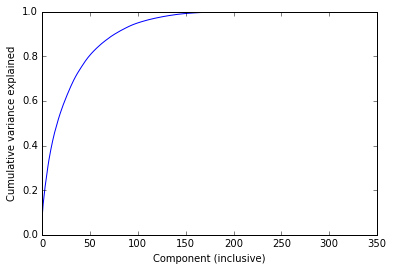

In [24]:
# pca -- seems to be about 100-150 dims
pca = Pipeline([
        ('std', StandardScaler()),
        ('pca', PCA()),
    ])

pca = pca.fit(X_train)
explained_variance_ratio = pca.steps[-1][-1].explained_variance_ratio_

plt.plot(np.cumsum(explained_variance_ratio))
plt.ylabel('Cumulative variance explained')
plt.xlabel('Component (inclusive)')

In [22]:
# pca -- see if loadings make any sense
components = pca.steps[-1][-1].components_
n_components = 5
n_loadings = 5
loadings = ''

for i in range(n_components):
    sort_idx = np.argsort(np.abs(components[i, :]))[::-1][:n_components]
    loadings += 'PC%d: ' % i
    for j in sort_idx:
        loadings += '%.2f*%s + '% (components[i, j], df_train.columns[j])
    loadings += '...\n\n'
print loadings

PC0: 0.15*num_var4 + 0.15*num_var35 + 0.15*num_op_var39_ult3 + 0.15*num_op_var39_ult1 + 0.15*num_op_var41_ult3 + ...

PC1: 0.20*num_var30_0 + 0.19*ind_var13_0 + 0.18*num_var13_0 + 0.18*ind_var13 + 0.18*num_var13 + ...

PC2: 0.22*ind_var31_0 + 0.22*ind_var31 + 0.19*num_var31 + 0.19*num_var31_0 + 0.16*ind_var44_0 + ...

PC3: -0.19*ind_var24 + -0.19*num_var24 + -0.19*ind_var24_0 + -0.19*num_var24_0 + -0.18*saldo_var12 + ...

PC4: 0.23*num_var1 + 0.23*ind_var1 + 0.23*ind_var40 + 0.23*num_var40 + 0.23*saldo_var40 + ...




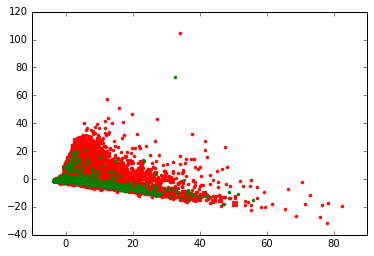

In [25]:
# pca -- see if any separability in projections
unsatisfied = y_train == 0
satisfied = y_train == 1

X_pca = pca.transform(X_train)

plt.plot(X_pca[unsatisfied, 0], X_pca[unsatisfied, 1], 'r.')
plt.plot(X_pca[satisfied, 0], X_pca[satisfied, 1], 'g.')

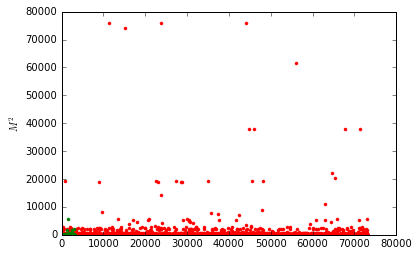

In [27]:
# potential outliers?
ee = EmpiricalCovariance()
ee = ee.fit(X_train)
m2 = ee.mahalanobis(X_train)

plt.plot(m2[unsatisfied], 'r.')
plt.plot(m2[satisfied], 'g.')
plt.ylabel('$M^2$')


Potential outliers 23/76020


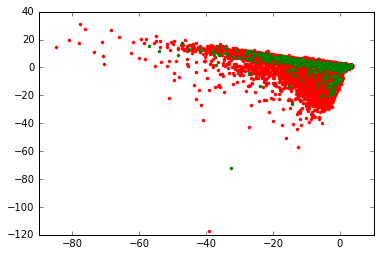

In [31]:
# pca -- rerun without outliers
inliers = m2 < 10000
print 'Potential outliers %d/%d' % (X_train.shape[0]-np.sum(inliers), X_train.shape[0])

X_train_in = X_train[inliers, :]
y_train_in = y_train[inliers]

pca = pca.fit(X_train[inliers, :])

unsatisfied = y_train_in == 0
satisfied = y_train_in == 1

X_pca = pca.transform(X_train_in)

plt.plot(X_pca[unsatisfied, 0], X_pca[unsatisfied, 1], 'r.')
plt.plot(X_pca[satisfied, 0], X_pca[satisfied, 1], 'g.')

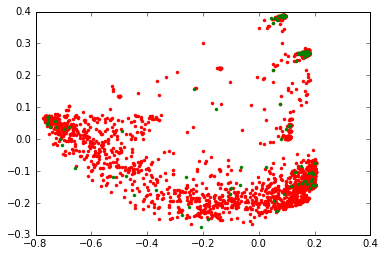

In [20]:
# kpca -- try with a smaller set of data to see if it becomes more easily separable
np.random.seed(0)

sample_pct = 0.05
sample_n = int(sample_pct * X_train.shape[0])
sample_idx = np.random.permutation(range(X_train.shape[0]))[:sample_n]

X_train_sub = X_train[sample_idx, :]
y_train_sub = y_train[sample_idx]

# pca -- seems to be about 100-150 dims
kpca = Pipeline([
        ('std', StandardScaler()),
        ('pca', KernelPCA(kernel='rbf')),
    ])
kpca = kpca.fit(X_train_sub)

unsatisfied = y_train_sub == 0
satisfied = y_train_sub == 1

X_kpca = kpca.transform(X_train_sub)

plt.plot(X_kpca[unsatisfied, 0], X_kpca[unsatisfied, 1], 'r.')
plt.plot(X_kpca[satisfied, 0], X_kpca[satisfied, 1], 'g.')